## Wprowadzenie

<p>W komunikacji bezprzewodowej przesyłanie wiadomości, czyli ciągu zer i jedynek, odbywa się za pomocą modulacji fali nośnej, wysyłanej z nadajnika. Istnieją trzy główne sposoby modulacji:

* Modulacja Amplitudowa (ASK)
* Modulacja Częstotliwościowa (FSK)
* Modulacja Fazowa (PSK)</p>

<p>W ramach tego projektu badane będą dwie odmiany modulacji fazowej, czyli Phase Shift Keying. Modulacja fazowa polega na przesunięciu fazy fali nośnej w zależności od tego, jaki fragment wiadomości jest przesyłany. Odmiany modulacji fazowej można podzielić ze względu na sposób modulacji oraz ze względu na sposób demodulacji. Podział metod PSK ze względu na sposób modulacji wynika z tego, ile przesunięć fazowych jest używanych do zakodowania bitów wiadomości. Najpopularniejsze z nich to :

* Binary Phase Shift Keying (BPSK)
* Quadrature Phase Shift Keying (QPSK)
* 8 Phase Shift Keying (8-PSK)</p>
<p>Demodulacja sygnału może odbywać się na dwa sposoby. Koherentna Modulacja Fazowa (CPSK) opiera się na odbiorze dostarczonego sygnału i określeniu jego fazy, porównując ją z fazą innego, odrębnego sygnału. Natomiast Różnicowa Modulacja Fazowa (DPSK), wyznacza bit bądź bity wiadomości, porównując fazę sygnału jednego bloku z fazą bloku poprzedniego.</p>
<p>W niniejszym sprawozdaniu przedstawione zostaną wyniki symulacji Koherentnych Modulacji Fazowych (CPSK), w których sygnał będzie kodowany na dwóch (BPSK) oraz czterech (QPSK) fazach. Ponadto modulacje zostaną porównane z modulacją amplidutową (ASK), w celu porównania, czy zmiana innego parametru fali nośnej byłaby bardziej optymalna przy przesyłaniu wiadomości.</p>

## Budowa symulatora
<p> Każda symulacja wygląda tak samo - najpierw inicjalizowane są podstawowe parametry symulacji, później generowana jest fala nośna, następnie generowana jest wiadomość, modulacja wiadomości, dodanie szumu do sygnału w celu zasymulowanie przejścia przez kanał transmisyjny, a na końcu demodulacja.</p>
<p> Na podstawie symulatora modulacji BPSK zostaną przedstawione i omówione wszystkie etapy. Na początku jest inicjalizacja modelu.</p>


```python
@dataclass
class Simulation:
    sampling_frec: int
    carry_frec: int
    bits_num: int
    noise: float
```

<p>Najważniejszymi parametrami każdego symulatora są: </p>

* Częstotliwość próbkowania (sampling_frec) - ilość próbek na jedną sekundę czasu trwania symulacji
* Częstotliwość fali nośnej (carry_frec) - częstotliwość fali, która będzie modulowana
* Liczba bitów (bits_num) - długość wiadomości
* Szum (noise) - odchylenie standardowe białego szumu gaussowskiego

### Fala nośna
<p>W zależności od modulatora, generowanie fal nośnych może się trochę różnić, lecz ogólny sposób jest jeden. Za pomocą biblioteki NumPy wygenerowana została wartość sinusa (bądź cosinusa) dla każdej próbki w dziedzinie. Następnie wszystkie wartości zapisano w tabeli, w formacie odpowiednim do tego, który będzie później potrzebny.</p>

```python
def BPSK_generate_carry_waves(carry_frec : int, time : np.ndarray, bits_num : int) -> np.ndarray:
    carry_wave = np.sin(2 * np.pi * carry_frec * time)
    carry_wave = np.split(carry_wave, bits_num)
    return carry_wave
```

### Wiadomość
<p>Wiadomość generowana jest za pomocą funkcji randint z biblioteki NumPy random. Wiadomość posiada długość równą ilości bitów.</p>

```python
def generate_signal(bits_num : int) -> np.ndarray:
    message = np.random.randint(2, size=bits_num)
    return message
```

### Szum
<p>Aby zasymulować przejście wiadomości przez kanał transmisyjny, do sygnału dodano biały szum gaussowski. Jego odchylenie standardowe jest równe temu, które zostało podane na początku symulacji.</p>

```python
def add_noise(noise : float, signal : np.ndarray) -> np.ndarray:
    noises = np.random.normal(0, noise, len(signal))
    noisy_signal = signal + noises
    return noisy_signal
```

### Obliczanie współczynnika błędów
<p>Współczynnik błędów (BER, Bit Error Rate) jest stosunkiem błędnie przesłanych bitów do ilości wszystkich bitów wiadomości. Obliczany jest po demodulacji, w celu sprawdzenia, jak dobrze działa modulacja.</p>

```python
def calculateBER(bits_num : int, original_message : np.ndarray, received_message : np.ndarray) -> float:
    errors = np.sum(original_message != received_message)
    ber = errors / bits_num
    return ber
```

<p>Powyższe funkcje są funkcjami pomocniczymi. Najważniejsza w symulacji jest modulacja oraz demodulacja sygnału.</p>

## Modulacja i Demodulacja
<p>Sygnał modulowany dzielony jest bloki, których długość zależy od ilości przesyłanych bitów. Następnie dla każdego bloku określa się fazę (bądź amplitudę) fali nośnej. Demodulator dzieli odebrany sygnał na tą samą ilość fragmentów i dla każdego ustala, jaki bit był zakodowany w podanym fragmencie.</p>

### Binarna modulacja fazowa (BPSK)
***
<p>Binarna modulacja fazowa opiera się na przesuwaniu fazy sygnału dla pojedynczego bitu. Jeżeli bit wynosi 0, faza fali ma pozostać taka, jaka była. Jeżeli bit wynosi 1, należy przesunąć sygnał o 180 stopni. Aby to zrobić, można zapisać fazy w formie punktów na tzw. <b>kole jednostkowym</b> (kole trygonometrycznym). Jest to koło, którego promień wynosi 1.</p>

<img src="images/unit_circ.png" alt="unit-circle" width="400/">

<i>Źródło: https://pl.wikipedia.org/wiki/Plik:Unit_circle_angles.svg</i>

<p>Należy zauważyć, że pierwsza współrzędna punktu na kole to wartość cosinusa, natomiast druga wartość to wartość sinusa. Zatem, aby przesunąć fazę sygnału, wystarczy przemnożyć fragment fali nośnej przez -1. Dla podanego przypadku falą nośną będzie sinus. Równania dla poszczególnych bitów będą wyglądały następująco</p>

$$
  s_0(t) = \sin(2\pi ft)
$$

$$
  s_1(t) = - \sin(2\pi ft)
$$

#### Modulacja BPSK

```python
def BPSK_modulation(message : np.ndarray, carry_wave : np.ndarray) -> np.ndarray:
    transmitted_signal = np.copy(carry_wave)
    for i in range(len(message)):
        if(message[i] == 1):
            transmitted_signal[i] = -1 * transmitted_signal[i]
    transmitted_signal = np.ravel(transmitted_signal)
    return transmitted_signal
```

Poniżej znajduje się przykładowy diagram konstelacji dla modulatora.

![bpsk model](images/bpsk_diag.png)
<p></p>
<i>Źródło: https://en.wikipedia.org/wiki/File:BPSK_Gray_Coded.svg</i>

<p>W demodulacji sygnał wyjściowy porównywany jest z falą nośną. Różnica w przesunięciu fazowym obu fal określa, jaki bit został zakodowany.</p>

#### Demodulacja BPSK

```python
def BPSK_demodulation(bits_num : int, signal : np.ndarray, carry_wave : np.ndarray) -> np.ndarray:
    received_signal = np.arange(bits_num)
    signal = np.split(signal, bits_num)
    for i in range(len(signal)):
        phase = np.sum(signal[i] * carry_wave[i])
        if(phase > 0):
            bit = 0
        else:
            bit = 1
        received_signal[i] = bit
    received_signal = np.asarray(received_signal)
    return received_signal
```

### Dwubitowa modulacja fazowa (QPSK)
***
<p>Modulacja QPSK jest bardziej skomplikowana od BPSK. Za pomocą jednej fazy kodowane są dwa bity. Każda faza oddalona jest od poprzedniej o 90 stopni - 45, 135, 225 i 315, natomiast ciągi bitów, które będą kodowane, to 11, 01, 00 i 10. Takie rozstawienie może zmniejszyć błędy transmisji. Na diagramie konstelacji ułożone są one w ten sposób</p>

![qpsk model](images/qpsk_diag.png)
<p></p>
<i>Źródło: https://en.wikipedia.org/wiki/Phase-shift_keying#/media/File:QPSK_Gray_Coded.svg</i>

<p>Można zauważyć, że do zakodowania bloku bitów potrzebne będą dwie fale nośne - jedna będzie kodowała bity parzyste (cosinus), a druga nieparzyste (sinus). Dla każdej fazy określa się znak obu tych fal, według znaków na kole jednostkowym (którego wartości na potrzeby modulacji zostały przemnożone przez dwa przez pierwiastek z dwóch, aby mieć liczby całkowite przy opisie punktów faz). W ten sposób wyznaczono cztery funkcje opisujące wszystkie kombinacje bitów.

$$
  s_{00}(t) = \sin(2\pi ft) + \cos(2\pi ft)
$$
$$
  s_{01}(t) = \sin(2\pi ft) - \cos(2\pi ft)
$$
$$
  s_{11}(t) = -\sin(2\pi ft) - \cos(2\pi ft)
$$
$$
  s_{10}(t) = -\sin(2\pi ft) + \cos(2\pi ft)
$$

</p>

#### Modulacja
<p>Dla każdej pary bitów określane są znaki funkcji. Na końcu fale są ze sobą łączone.</p>

```python
def QPSK_modulation(message : np.ndarray, carry_waves : list) -> np.ndarray:
    trans_i = np.copy(carry_waves[0])
    trans_q = np.copy(carry_waves[1])

    for i in range(len(carry_waves[0])):
        if (message[2*i] == 0):
            q_sing = 1
        else:
            q_sing = -1
        if (message[2*i+1] == 0):
            i_sing = 1
        else:
            i_sing = -1
        trans_i[i] = i_sing * trans_i[i]
        trans_q[i] = q_sing * trans_q[i]

    trans_i = np.ravel(trans_i)
    trans_q = np.ravel(trans_q)
    transmitted_signal = trans_i + trans_q
    return transmitted_signal
```


#### Demodulacja
<p>Demodulacja QPSK jest podobna do demodulacji BPSK, tylko przy porównywaniu odebrany sygnał jest porównywany najpierw z falą dla liczb parzystych a następnie z falą liczb nieparzystych. Na tej podstawie określane są kolejne bity</p>

```python
def QPSK_demodulation(bits_num : int, signal : np.ndarray, carry_waves : list) -> np.ndarray:
    carry_i = carry_waves[0]
    carry_q = carry_waves[1]

    received_signal = np.arange(bits_num)
    signal = np.split(signal, bits_num/2)

    for i in range(len(signal)):
        in_phase = np.sum(signal[i] * carry_i[i])
        quadrature = np.sum(signal[i] * carry_q[i])
        if(in_phase > 0):
            q_bit = 0
        else:
            q_bit = 1
        if(quadrature > 0):
            i_bit = 0
        else:
            i_bit = 1
        received_signal[2*i] = i_bit
        received_signal[2*i+1] = q_bit

    received_signal = np.asarray(received_signal)
    return received_signal
```

<p>Modulacja QPSK jest najbardziej skomplikowaną modulacją omawianą w tym sprawozdaniu. Wynika to z potrzebą użycia dwóch fal nośnych do zakodowania informacji.</p>

### Modulacja amplitudowa (ASK)
***
<p>Implementując Modulację Amplitudową (ASK), można zbadać, czy zmiana innego parametru fali nośnej wpływa na zmniejszenie bądź zwiększenie współczynnika błędów.</p>
<p>W modulacji amplitudowej manipuluje się amplitudą. Jeżeli bit wiadomości wynosi 1, amplituda fali nośnej się nie zmienia. Jeżeli wynosi 0, amplituda fali nośnej zmniejsza się do zera. Można to określić za pomocą równania

$$
  s_{n}(t) = n \cdot \sin(2\pi ft)
$$
</p>


#### Modulacja

```python
def ASK_modulation(samp_per_bit : int, message : np.ndarray, carry_wave : np.ndarray) -> np.ndarray:
    cont_msg = np.repeat(message, samp_per_bit)
    transmited_signal = carry_wave * cont_msg
    return transmited_signal
```

#### Demodulacja
<p>W tej implementacji demodulacja sygnału jest dosyć prymitywna. Najpierw dla każdej próbki sprawdza się, czy amplituda nie przekroczyła 0.4 (czyli około połowy domyślnej amplitudy). Następnie na podstawie ilości przekroczonych amplitud określa się, czy dany fragment zakodował 0 czy 1.</p>

```python
def ASK_demodulation(sampling_frec : int, bits_num : int, samp_per_bit: int, signal : np.ndarray) -> np.ndarray:
    recieved_signal = np.zeros(sampling_frec)
    signal = np.absolute(signal)

    for i in range(sampling_frec):
        if(signal[i] > 0.4):
            recieved_signal[i] = 1
        else:
            recieved_signal[i] = 0

    splited = np.split(recieved_signal, bits_num)
    recieved_message = []

    for array in splited:
        arr_sum = np.sum(array)
        if(arr_sum > (samp_per_bit/2)):
            recieved_message.append(1)
        else:
            recieved_message.append(0)
            
    recieved_message = np.asarray(recieved_message)
    return recieved_message
```

Po omówieniu kodu można zaprezentować działanie modelu.

## Prezentacja działania modelu
<p>Aby zwizualizować działanie modelów, przeprowadzona zostanie jednorazowa symulacja. Na wykresach znajduje się oryginalna wiadomość, wiadomość po modulacji, wiadomość po dodaniu szumu oraz wiadomość odebrana.</p>

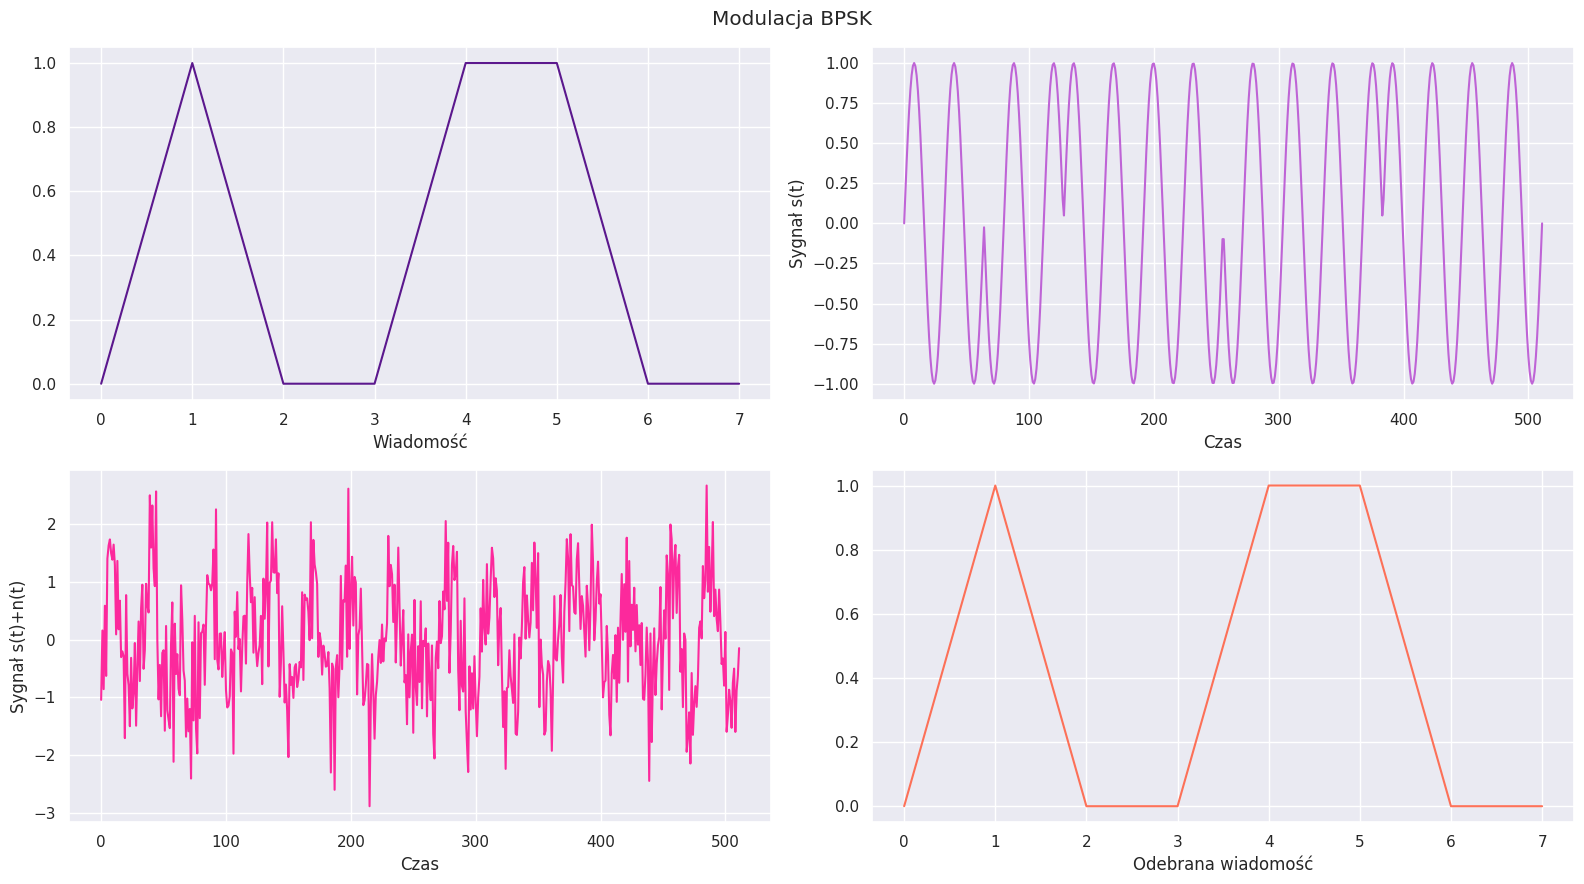

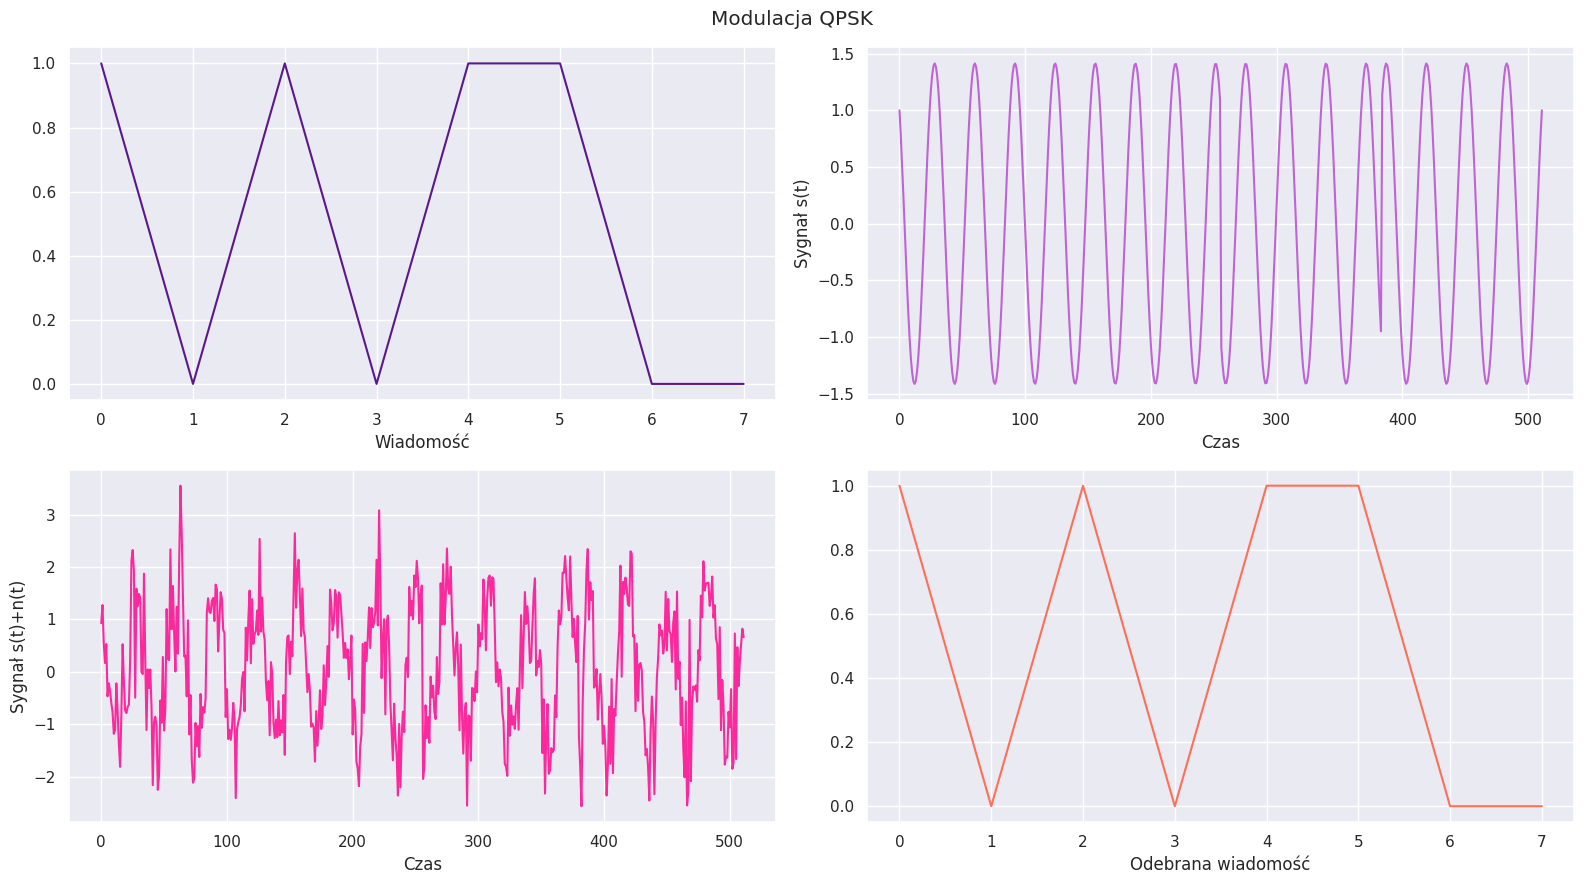

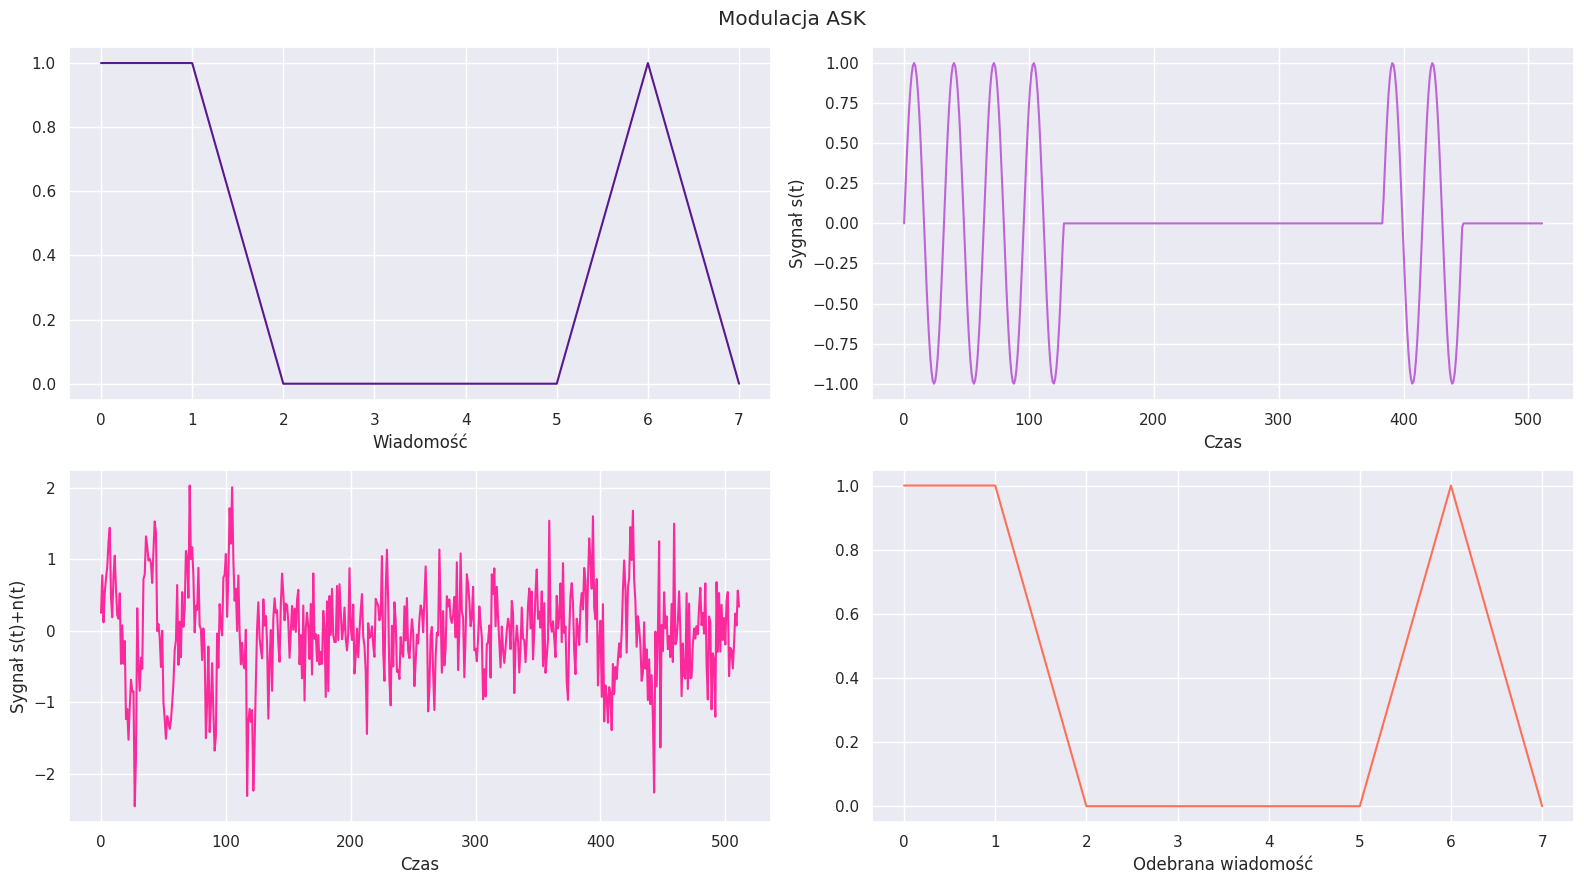

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import psksimulator
import psksimulator.modulations
import psksimulator.signals
import psksimulator.simulation
import psksimulator.visualization

simulation = psksimulator.simulation.Simulation(512, 16, 8, 0.7)
time = np.linspace(0, 1, simulation.sampling_frec)

# BPSK simulation
carry_wave = psksimulator.signals.BPSK_generate_carry_waves(simulation.carry_frec,time=time,bits_num=simulation.bits_num)
message = psksimulator.signals.generate_signal(simulation.bits_num)
signal = psksimulator.modulations.BPSK_modulation(message, carry_wave)
noisy_signal = psksimulator.signals.add_noise(simulation.noise, signal)
received_signal = psksimulator.modulations.BPSK_demodulation(simulation.bits_num, noisy_signal, carry_wave)
signals = { 'message'  : message, 'signal'   : signal, 'noises'   : noisy_signal, 'received' : received_signal }
psksimulator.visualization.plot_signals('BPSK', signals)

# QPSK simulation
carry_waves = psksimulator.signals.QPSK_generate_carry_waves(simulation.carry_frec,time=time,bits_num=simulation.bits_num)
message = psksimulator.signals.generate_signal(simulation.bits_num)
signal = psksimulator.modulations.QPSK_modulation(message, carry_waves)
noisy_signal = psksimulator.signals.add_noise(simulation.noise, signal)
received_signal = psksimulator.modulations.QPSK_demodulation(simulation.bits_num, noisy_signal, carry_waves)
signals = { 'message'  : message, 'signal'   : signal, 'noises'   : noisy_signal, 'received' : received_signal }
psksimulator.visualization.plot_signals('QPSK', signals)

# ASK simulation
simulation.noise = 0.5
samp_per_bit = int(simulation.sampling_frec / simulation.bits_num)
carry_wave = psksimulator.signals.ASK_generate_carry_waves(simulation.carry_frec,time=time)
message = psksimulator.signals.generate_signal(simulation.bits_num)
signal = psksimulator.modulations.ASK_modulation(samp_per_bit, message, carry_wave)
noisy_signal = psksimulator.signals.add_noise(simulation.noise, signal)
received_signal = psksimulator.modulations.ASK_demodulation(simulation.sampling_frec, simulation.bits_num, samp_per_bit, noisy_signal)
signals = { 'message'  : message, 'signal'   : signal, 'noises'   : noisy_signal, 'received' : received_signal }
psksimulator.visualization.plot_signals('ASK', signals)

<p>Przykładowe przebiegi symulacji były przeprowadzane na parametrach:</p>

* Częstotliwość próbkowania - 512 Hz
* Częstotliwość fali nośnej - 16 Hz
* Ilość bitów - 8
* Szum - 0.7 (dla ASK 0.5)

### Bitowy współczynnik błędów (BER)

<p>W celu sprawdzenia, który model ma najmniejszy bitowy współczynnik błędów. <b>Bitowy współczynnik błędów (BER)</b> to stosunek źle przesłanych bitów do całkowitej ilości bitów w wiadomości. Zależy on głównie od warunków, jakie panują w kanale transmisyjnym, np. szumu lub interferencji wiadomości z innymi sygnałami.</p>
<p>W ramach badań w kanale transmisyjnym zasymulowano biały szum gaussowki (AWGN). Jego odchylenie standardowe w badaniach zależało od znormalizowanego stosunku fali nośnej do szumu (carrier-to-noise, CNR), czyli energia na bit do współczynnika mocy szumu (Eb/No). Użyto do tego następujących wzorów</p>

$$
  E_{b}N_{o} = 10 \cdot (E_{b}No_{dB} \cdot 10)
$$
$$
  N = \frac{1}{\sqrt{2\cdot E_{b}N_{o}}}
$$

<p>Badania zależności BER od CNR dla każdego modelu przeprowadzono na następujących parametrach</p>

* Częstotliwość próbkowania - 16384 Hz
* Częstotliwość fali nośnej - 4096 Hz
* Ilość bitów - 2048

<p>Ze względu na krótką wiadomość (tylko 2048 bitów) szum został zwiększony czterokrotnie, aby móc zaobserwować jakiekolwiek skutki zakłóceń.</p>

<p>Wyniki w tabeli wyglądają tak</p>

In [2]:
df = pd.read_csv('output/bers.csv', delimiter=';')
df.head()

,Model,Sampling Frec,Carry Frec,Bits Num,Noise,BER,EbNo(dB)
0,BPSK,16384,4096,2048,2.8,0.244141,0
1,BPSK,16384,4096,2048,2.5,0.210449,1
2,BPSK,16384,4096,2048,2.2,0.188965,2
3,BPSK,16384,4096,2048,2.0,0.145508,3
4,BPSK,16384,4096,2048,1.8,0.135742,4


<p>Poniżej narysowano wykres przedstawiający BER z podziałem na modele.</p>

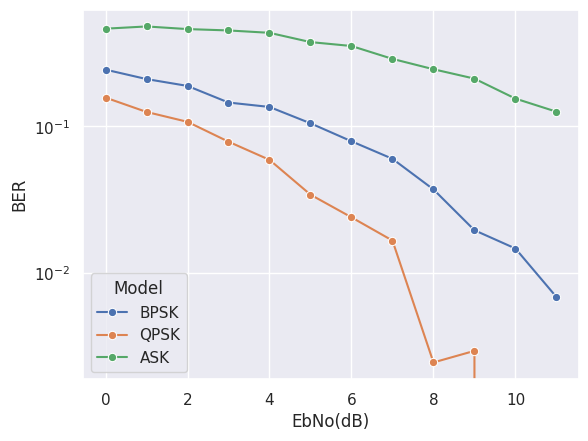

In [3]:
sns.lineplot(
    data=df,
    x="EbNo(dB)", y="BER", hue="Model", markers=True, dashes=True, marker='o'
)
plt.xscale('linear')
plt.yscale('log')
plt.xlabel('EbNo(dB)')
plt.ylabel('BER')
plt.grid(True)

<p>Z wykresu przedstawionego powyżej można wywnioskować, że im większy jest stosunek sygnału do szumu, tym mniejszy jest współczynnik błędów. Wyniki można porównać jeszcze z założeniami teoretycznymi.</p>

<img src="images/PSK_BER_curves.png" alt="ber-curves" width="500/">

<i>Źródło: https://en.wikipedia.org/wiki/Eb/N0#/media/File:PSK_BER_curves.svg</i>

<p>Ze względu na zwiększenie szumu, BER na wykresie jest większy od teoretycznie zakładanych wartości, lecz kształt krzywej oraz spadek wartości pokazuje, że zaimplementowane modele działają prawidłowo.</p>

## Wnioski i podsumowanie
<p>Z powyższych wykresów można wywnioskować, że najbardziej skuteczną modulacją ze wszystkich przedstawionych w tym projekcie, jest QPSK. Największy współczynnik błędów posiadała modulacja ASK.</p>
<p>Aby zmniejszyć prawdopodobieństwo wystąpienia błędu na poziomie samego przesyłania sygnału, należy wzmocnić siłę fali nośnej bądź postarać się o zmniejszenie zakłóceń w kanale transmisyjnym. Na tym można zakończyć dalsze rozważania.</p>

## Referencje

1. https://en.wikipedia.org/wiki/Phase-shift_keying
2. https://en.wikipedia.org/wiki/Bit_error_rate